# 1. DATASET 구성

다운로드  
[aihub_27_classes_label.csv](https://www.dropbox.com/s/mh3yeeu22h8spqb/aihub_27_classes_label.csv
)  
[aihub_13_classes_label.csv](https://www.dropbox.com/s/byecey0zebrn203/aihub_13_classes_label.csv
)

```
${DATASET_ROOT}
 `-- customize_label.csv
  -- train`
     |-- data1
     |   |-- data1.xml
     |   |-- MP_SEL_000001.jpg
     |   |-- MP_SEL_000002.jpg
     |   |-- MP_SEL_000003.jpg
     |   |-- MP_SEL_000004.jpg
     |   |-- ...
     |-- data2
     |   |-- data2.xml
     |   |-- MP_SEL_000201.jpg
     |   |-- MP_SEL_000202.jpg
     |   |-- MP_SEL_000203.jpg
     |   |-- MP_SEL_000204.jpg
     |   |-- ...
     |-- data3
     |   |-- data3.xml
     |   |-- MP_SEL_000601.jpg
     |   |-- MP_SEL_000602.jpg
     |   |-- MP_SEL_000603.jpg
     |   |-- MP_SEL_000604.jpg
     |   |-- ...
```

In [ ]:
# to deal with xml files
%pip install xmltodict

In [ ]:
# 기본 설정
import os
# detectron2 logger 설정
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# 자주 사용하는 라이브러리 임폴트
import csv
import torch, torchvision
import numpy as np
import cv2
import json
import itertools
from glob import glob
import xml.etree.ElementTree as elemTree

# 자주 사용하는 detectron2 utils imoprt
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.structures import BoxMode

print(torch.__version__)

In [ ]:
DATASET_ROOT = 'D:/Bbox' # dataset Driectory Root만 수정해주세요, 최상단 파일 배치도랑 맞춰주세요
train_val_path = 'train'

# 2. 레이블 파일 불러오기 

In [ ]:
def get_label_list(label_path):
    
    labels = []

    with open(label_path) as csvfile:
        readCSV = csv.reader(csvfile, delimiter=',')
        for row in readCSV:
            labels.append(row[0])
    return labels

label_path = os.path.join(DATASET_ROOT, "customize_label.csv")
labels = get_label_list(label_path)
print(labels)

# 3. get_crosswalk_dicts 함수 작성
Detectron2에 Dataset 등록을 위해 필요한 함수를 작성합니다.  
같은 방법으로 validation dataset을 구성하여 학습에 이용할 수 있습니다. 

In [ ]:
def get_crosswalk_dicts():
    
    label_path = os.path.join(DATASET_ROOT, "customize_label.csv")
    image_path = os.path.join(DATASET_ROOT, train_val_path)
    
    dirs = glob(os.path.join(image_path,'*'))
    xmls = glob(os.path.join(image_path,'*/*.xml'))
    
    labels = get_label_list(label_path)
    dataset_dicts = []
    #for xml in xmls:
    for sub_dir in dirs:

        xml_path = os.path.join(sub_dir,glob(os.path.join(sub_dir,"*.xml"))[0])
        images_path = glob(os.path.join(sub_dir,"*.jpg"))
        tree = elemTree.parse(xml_path)
        for image in tree.findall('./image'):
            
            jpg_name = os.path.join(sub_dir,image.attrib['name'])
            if not jpg_name in images_path:
                print("pass because no image -> {}".format(jpg_name))
                continue
            
            record = {}
            record["file_name"] = jpg_name
            record["height"] = int(image.attrib['height'])
            record["width"] = int(image.attrib['width'])
        
            objs = []
            for box in image.findall('./box'):
                if box.attrib['label'] not in labels:
                  continue
                obj = {
                    "bbox": [
                        float(box.attrib['xtl']), 
                        float(box.attrib['ytl']), 
                        float(box.attrib['xbr']), 
                        float(box.attrib['ybr'])],
                    "bbox_mode": BoxMode.XYXY_ABS,
                    # category_id should be customized
                    "category_id": labels.index(box.attrib['label']),
                    "iscrowd": 0
                }
                objs.append(obj)
            record["annotations"] = objs
            dataset_dicts.append(record)
    return dataset_dicts

# 4. 데이터셋 등록   

In [ ]:
# Register Train Datasets
from detectron2.data import DatasetCatalog, MetadataCatalog
DatasetCatalog.register("crosswalk/train", get_crosswalk_dicts)
MetadataCatalog.get("crosswalk/train").set(thing_classes=labels)
crosswalk_metadata = MetadataCatalog.get("crosswalk/train")

In [ ]:
# 잘 등록되었나 확인 
import random
import matplotlib.pyplot as plt
%matplotlib inline

def cv2_imshow(image):
    plt.figure(figsize=(20,20))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()
    
dataset_dicts = get_crosswalk_dicts()
# 샘플의 개수 설정
"""for d in random.sample(dataset_dicts, 1):
    img = cv2.imread(d["file_name"])
    #이미지의 크기 조절
    visualizer = Visualizer(img[:, :, ::-1], metadata=crosswalk_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])"""

# 5. RetinaNet 학습하기

In [ ]:
#os.chdir("/home/visionnoob/git_project/detectron2")
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("crosswalk/train",)
cfg.DATASETS.TEST = ()   # no metrics implemented for this dataset
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_50_FPN_3x.yaml")
cfg.MODEL.WEIGHTS = "MK-4/model_final.pth"
cfg.SOLVER.IMS_PER_BATCH = 3 # GPU 메모리에 따라서 BATCH SIZE 조절 부탁드려요
# cfg.SOLVER.BASE_LR = 0.000005
cfg.SOLVER.BASE_LR = 0.001 # 값 너무 크게 준것 같아서 위에걸로 시도해보면 좋을 것 같아요
cfg.SOLVER.STEPS = []        # do not decay learning rate

epoch = len(dataset_dicts) // cfg.SOLVER.IMS_PER_BATCH # epoch 1

cfg.SOLVER.MAX_ITER = epoch * 2    # Iteration
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 1024
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 16  # 클래스 개수

In [ ]:
print(len(dataset_dicts))

In [ ]:
# GPU에 맞게 torch와 cuda 버전 부탁드려요
torch.cuda.is_available()
torch.__version__

In [ ]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=True)

In [12]:
trainer.train() # 해당 directory output 폴더에 model 생성됩니다

[05/31 22:44:24 d2.utils.events]:  eta: 1 day, 4:03:32  iter: 759  total_loss: 0.3686  loss_cls: 0.1572  loss_box_reg: 0.2128  time: 0.4735  data_time: 0.0015  lr: 0.00075924  max_mem: 5610M
[05/31 22:44:33 d2.utils.events]:  eta: 1 day, 4:03:29  iter: 779  total_loss: 0.3073  loss_cls: 0.1386  loss_box_reg: 0.1784  time: 0.4735  data_time: 0.0016  lr: 0.00077922  max_mem: 5610M
[05/31 22:44:42 d2.utils.events]:  eta: 1 day, 4:02:38  iter: 799  total_loss: 0.364  loss_cls: 0.1618  loss_box_reg: 0.2048  time: 0.4729  data_time: 0.0015  lr: 0.0007992  max_mem: 5610M
[05/31 22:44:51 d2.utils.events]:  eta: 1 day, 4:01:53  iter: 819  total_loss: 0.3585  loss_cls: 0.1376  loss_box_reg: 0.2142  time: 0.4722  data_time: 0.0015  lr: 0.00081918  max_mem: 5610M
[05/31 22:45:00 d2.utils.events]:  eta: 1 day, 4:00:39  iter: 839  total_loss: 0.4208  loss_cls: 0.1661  loss_box_reg: 0.252  time: 0.4716  data_time: 0.0016  lr: 0.00083916  max_mem: 5610M
[05/31 22:45:09 d2.utils.events]:  eta: 1 day, 3

In [13]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

Reusing TensorBoard on port 6006 (pid 24084), started 6 days, 14:28:52 ago. (Use '!kill 24084' to kill it.)

In [ ]:
cfg.MODEL.WEIGHTS = "MK-3/model_final.pth" # model path
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
predictor = DefaultPredictor(cfg)

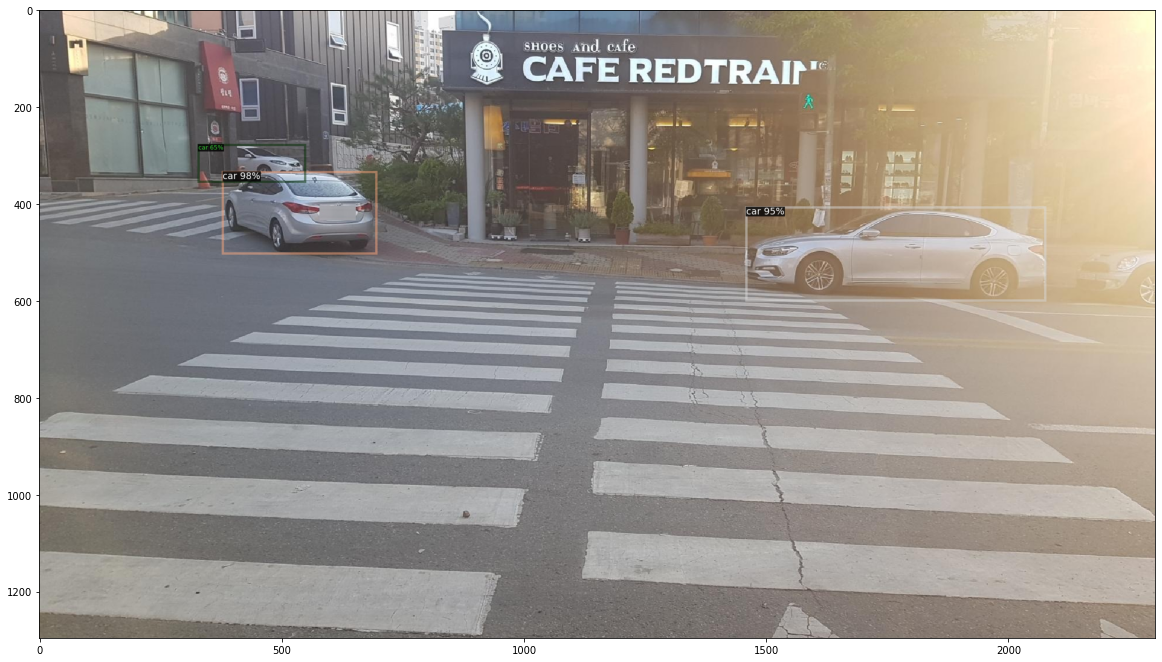

In [17]:
path = "D:/Bbox/train/Bbox_0001/MP_SEL_000004.jpg" # 예측해볼 파일입니다. Train할 때 이용한 파일인데도 학습이 잘 안됐네요.

im = cv2.imread(path)
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])